In [1]:
import numpy as np

import argparse, cv2, os, sys, math, random

from pathlib import *

from matplotlib import pyplot as plt

from PIL import Image

from scipy import ndimage

# p1

In [2]:
# General Function:

def rec_crop(image,width,height): # crop a rectangular area 
    h,w = image.shape[:2]
    x=int(np.random.rand(1)*(w-width))
    y=int(np.random.rand(1)*(h-height))
    img_cropped = np.copy(image[y:y+height, x:x+width])
    return img_cropped

def translate_normal(image, W, H):
    (h,w)=image.shape[:2]
    times_H = int(H/h)+1
    times_W = int(W/w)+1  
    p1=image
    for j in range(1,times_H):
        p1=np.concatenate((p1,image))       
    p2=p1   
    for i in range(1,times_W):
        p2=np.concatenate((p2, p1),axis=1)   
    img_trans = p2[:H, :W] 
    return img_trans

def obli_crop(crop, theta): #theta is angle of oblique
    b=crop.shape[0]
    crop1=np.copy(crop)
    (h,w)=crop1.shape[:2]
    theta = math.radians(theta)
    tan = math.tan(theta)
    for i in range (0,h):
        crop1[i,0:int((h-i)/tan),:]=0    
    crop1=np.rot90(crop1,2)
    for i in range (0,h):
        crop1[i,0:int((h-i)/tan),:]=0            
    crop1=np.rot90(crop1,2)
    crop1 = crop1/255.
    return crop1

def translate_obli(pri_cell, W, H):
    h,w = pri_cell.shape[:2]
    rh = h
    start,end = 0,0
    rw_set = list(np.ones((h))*w)
    
    for j in range (0,h-1):
        for i in range (0,w-1):
            if np.sum(pri_cell[j,i,:])==0 and np.sum(pri_cell[j,i+1,:])!=0:
                start = i
            if np.sum(pri_cell[j,i,:])!=0 and np.sum(pri_cell[j,i+1,:])==0:
                end = i
            rw_set[j]=end-start-1
    rw = int(max(rw_set, key = rw_set.count)) #return most frequent number
    
    extra_times = int(w/rw)+1
    times_w=int(W/rw+2*extra_times)
    img = np.zeros((h, int(rw*times_w), 3))
    img[:h,:w,:]=np.copy(pri_cell)
    
    for i in range (0,h):
        for j in range (rw, rw*times_w-rw):
            if np.sum(img[i,j:(j+rw),:])==0 and np.sum(img[i,j-1,:])!=0:
                img[i,j:(j+rw),:]=img[i,(j-rw):j,:]
    start_w = rw*(int(w/rw)+1)
    img = img[:,start_w:int(rw*times_w-rw),:]

    rolled = np.copy(img)
    times_h=int(H/h+1)
    for t in range (0, times_h):
        rolled = np.roll(rolled, 2*rw-w, axis=1)
        img = np.vstack((img,rolled))

    img = img[:H,:W,:]  
    return img

def rhomb_crop(image):
    (h,w)=image.shape[:2]
    crop2=np.copy(image)
    for n in range (0,2):
        for i in range (0,int(h/2)):
            crop2[i,0:int(w/2-i*w/h),:]=0
            crop2[i,int(w/2+i*w/h):w,:]=0
        crop2=np.rot90(crop2,2)
    return crop2

def rhombic_unit(crop):  
    #roll and fill the four corner to create a unit that can be translated
    h,w=crop.shape[:2]
    roll0 = np.roll(np.roll(crop, round(h/2), axis=0), round(w/2), axis=1)
    merged=np.copy(crop)
    for i in range (0,h):
        for j in range (0,w):
            if np.sum(merged[i,j,:])==0:
                merged[i,j,:]=np.copy(roll0[i,j,:])
    return merged

def border(image): # vague the border
    h,w = image.shape[:2]
    for i in range (0,h-1):
        for j in range (1,w-1):
            if np.sum(image[i,j-1,:])!=0 and np.sum(image[i,j+1,:])!=0 and np.sum(image[i,j,:])==0:
                image[i,j,:] = np.copy(image[i,j+1,:])
            if np.sum(image[i-1,j,:])!=0 and np.sum(image[i+1,j,:])!=0 and np.sum(image[i,j,:])==0:
                image[i,j,:] = np.copy(image[i+1,j,:])
    for i in range (0,h):
        if np.sum(image[i,0,:])==0:
            image[i,0,:]=np.copy(image[i,1,:])
        if np.sum(image[i,w-1,:])==0:
            image[i,w-1,:]=np.copy(image[i,w-2,:])
    for j in range (0,w):
        if np.sum(image[h-1,j,:])==0:
            image[h-1,j,:]=np.copy(image[h-2,j,:])
    return image

def remove_border(img):
    copy = np.copy(img)
    for i in range (0,4):
        hh = copy.shape[:1]
        while np.sum(copy[0,:,:])==0:
            copy = np.copy(copy[1:hh])
#         copy = np.copy(copy[1:hh])
        copy = np.rot90(copy)
    return copy

def rhombic_edge(image):
    img = np.copy(image)
    h,w = img.shape[:2]
    times = 1
    for i in range (0,int(h/2)):
        for j in range (0,int(w/2)):
            if np.sum(img[i,j,:])==0:
                t=1
                i_h = i
                if i_h < h-1:
                    while np.sum(img[i_h+1,j,:])==0:
                        t=t+1
                        i_h = i_h+1
                    if t > times:
                        times = t
    for q in range(0,times):
        img_1 = np.roll(img,1,axis=0)
        for i in range (0,h):
            for j in range (0,w):
                if np.sum(img[i,j,:])==0:
                    img[i,j,:]=np.copy(img_1[i,j,:])
    return img

In [3]:
# Transformations:

def p1_rectangular(image,unit_w,unit_h,Width,Height): 
    rec_unit = rec_crop(image,unit_w,unit_h)
    rec = translate_normal(rec_unit,Width,Height) 
    return rec

def p1_square(image,side_length,Width,Height):  # only need side length
    squ_unit = rec_crop(image,side_length, side_length)
    squ = translate_normal(squ_unit,Width,Height) 
    return squ

def p1_oblique(image, unit_width, unit_height, angle, Width, Height):
     # Angle is for left bottom corner
    rec = rec_crop(image, unit_width, unit_height)  
    crop = obli_crop(rec, angle) 
    obli = translate_obli(crop, Width, Height)
    return obli

def p1_hexagonal(image, side_length, Width, Height): 
    # cropped rectangular width/height=sqrt(3)
    rec = rec_crop(image,int(side_length * math.sqrt(3)),side_length) 
    crop = obli_crop(rec,60) # Hexagonal is oblique with 60 degree corner
    hexa = translate_obli(crop,Width,Height)
    hexa = border(hexa) # take care of border of unit cell
    return hexa

def p1_rhombic(image, unit_width, unit_height, Width, Height):
    rec = rec_crop(image,unit_width, unit_height)
    crop = rhomb_crop(rec) 
    rhomb_unit = rhombic_unit(crop)
    rhomb = translate_normal(rhomb_unit,Width,Height) 
    rhomb = rhombic_edge(rhomb) # take care of image's wierd edge
    return rhomb

# Validate with image sample

In [3]:
import cv2, math, os, random
import numpy as np
import matplotlib.pyplot as plt

# Load image

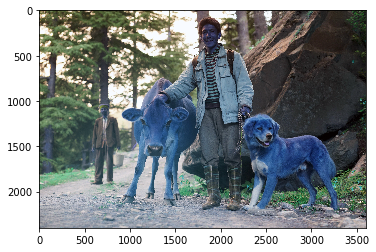

In [5]:
# use image samples for demontration
ori = cv2.imread('/home/yig319/Dropbox/wallpaper_group_generator/Original_images/dog-park.png') # load image used to crop and transform
image1 = np.copy(ori) 
imgplot = plt.imshow(image1)

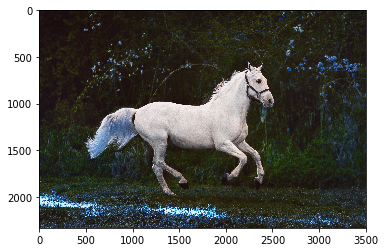

In [6]:
# use image samples for demontration
ori = cv2.imread('/home/yig319/Dropbox/wallpaper_group_generator/Original_images/horse.png') 
image2 = np.copy(ori) # load image used to crop and transform
imgplot = plt.imshow(image2)

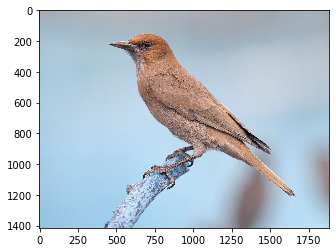

In [7]:
# use image samples for demontration
ori = cv2.imread('/home/yig319/Dropbox/wallpaper_group_generator/Original_images/bird.png') 
image3 = np.copy(ori) # load image used to crop and transform
imgplot = plt.imshow(image3)

# Set image size

In [8]:
#set output image size 
width, height = (256, 256)

# use random size and angle as croped part of image
angle = random.randint(30,85)
unit_h = random.randint(20,80)
lower_bound_w = int(unit_h/math.tan(math.radians(angle)))
if lower_bound_w > 65:
    unit_w = random.randint(lower_bound_w+15, lower_bound_w+75)
else: 
    unit_w = random.randint(lower_bound_w+15, 85)
    
# width, length, angle of unit cell:
unit_w, unit_h, angle

(85, 47, 51)

# Transform

In [9]:
p1_1 = p1_rectangular(image1,unit_w,unit_h,width,height)
p1_2 = p1_square(image1,unit_w,width,height)
p1_3 = p1_oblique(image1,unit_w*2,unit_h,angle,width,height) 
p1_4 = p1_hexagonal(image1,unit_w*2,width,height)
p1_5 = p1_rhombic(image1,unit_w,unit_h,width,height) 

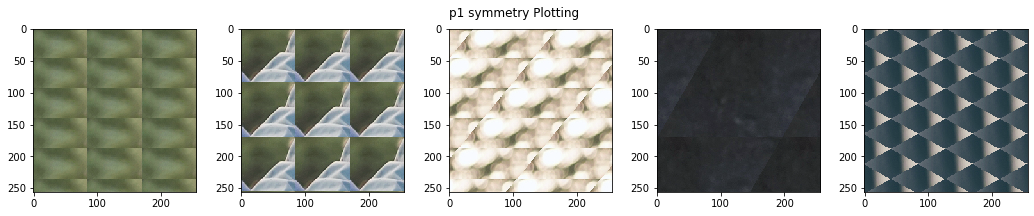

In [10]:
plt.figure(figsize=(18, 3))
plt.subplot(151)
plt.imshow(p1_1)
plt.subplot(152)
plt.imshow(p1_2)
plt.subplot(153)
plt.imshow(p1_3)
plt.subplot(154)
plt.imshow(p1_4)
plt.subplot(155)
plt.imshow(p1_5)
plt.suptitle('p1 symmetry Plotting')
plt.show()

In [11]:
p1_1 = p1_rectangular(image2,unit_w,unit_h,width,height)
p1_2 = p1_square(image2,unit_w,width,height)
p1_3 = p1_oblique(image2,unit_w*2,unit_h,angle,width,height) 
p1_4 = p1_hexagonal(image2,unit_w*2,width,height)
p1_5 = p1_rhombic(image2,unit_w,unit_h,width,height) 

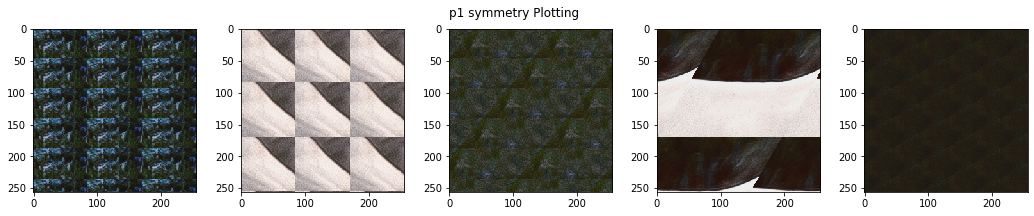

In [12]:
plt.figure(figsize=(18, 3))
plt.subplot(151)
plt.imshow(p1_1)
plt.subplot(152)
plt.imshow(p1_2)
plt.subplot(153)
plt.imshow(p1_3)
plt.subplot(154)
plt.imshow(p1_4)
plt.subplot(155)
plt.imshow(p1_5)
plt.suptitle('p1 symmetry Plotting')
plt.show()

In [13]:
p1_1 = p1_rectangular(image3,unit_w,unit_h,width,height)
p1_2 = p1_square(image3,unit_w,width,height)
p1_3 = p1_oblique(image3,unit_w*2,unit_h,angle,width,height) 
p1_4 = p1_hexagonal(image3,unit_w*2,width,height)
p1_5 = p1_rhombic(image3,unit_w,unit_h,width,height) 

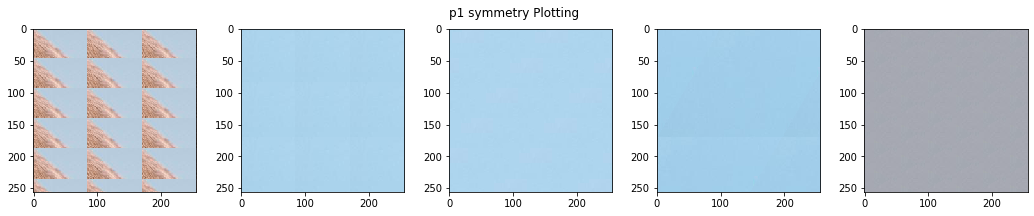

In [14]:
plt.figure(figsize=(18, 3))
plt.subplot(151)
plt.imshow(p1_1)
plt.subplot(152)
plt.imshow(p1_2)
plt.subplot(153)
plt.imshow(p1_3)
plt.subplot(154)
plt.imshow(p1_4)
plt.subplot(155)
plt.imshow(p1_5)
plt.suptitle('p1 symmetry Plotting')
plt.show()